### Technical Report: Analysis and Forecasting of Walmart Store Sales

#### Objective
The objective of this analysis is to predict future weekly sales for Walmart stores accurately. This helps the store management plan inventory, optimize supply chain logistics, and schedule promotional events, especially during peak sales periods such as holidays.

#### Dataset Overview
The dataset spans weekly sales data for **45 Walmart stores** from **February 2010 to October 2012**. Each data entry contains:
- **Store**: Identifier for the store.
- **Date**: The week of sales.
- **Weekly_Sales**: Total sales for the given store and week.
- **Holiday_Flag**: Indicates if the week includes a major holiday (1 for holiday weeks, 0 for non-holiday weeks).
- **Temperature, Fuel_Price, CPI, Unemployment**: Economic indicators that may affect sales.

For this analysis, we focused on **Store 1** to develop and test models for forecasting.

#### Exploratory Data Analysis (EDA)

1. **Overall Sales Trend**:
   - A time series plot of weekly sales for Store 1 revealed noticeable cyclical patterns with significant peaks during known holidays, such as Thanksgiving and Christmas. These peaks suggest that holiday weeks greatly influence sales, confirming the need for targeted forecasting.

2. **Holiday Impact on Sales**:
   - A box plot comparing sales during holiday and non-holiday weeks showed that sales were significantly higher during holiday weeks. The median sales in holiday weeks were higher, and there was a larger spread in the data, indicating variability due to factors such as holiday promotions and increased customer spending.
   - **Key Insight**: Forecasting models need to account for holiday effects to improve prediction accuracy during peak periods.

3. **Sales Trends by Year**:
   - Analyzing sales trends for each year indicated that seasonal peaks were consistent, especially around the 11th month (November) and 12th month (December), aligning with major U.S. holidays.
   - **Observation**: Understanding these consistent peaks is crucial for planning stock and promotions.

4. **Correlation Analysis**:
   - A correlation matrix for weekly sales and economic factors (temperature, fuel price, CPI, and unemployment) showed:
     - **Weak positive correlation** between temperature and sales, suggesting that warmer weather might slightly influence shopping behavior.
     - **Minimal or negligible correlations** between sales and other economic indicators, implying that these variables alone do not significantly affect weekly sales.
   - **Insight**: While economic factors are part of the analysis, trends and seasonality play a more critical role in influencing weekly sales.

5. **Seasonality Check**:
   - A deeper analysis using autocorrelation functions (ACF) confirmed the presence of strong seasonality at a lag of approximately 52 weeks, representing yearly patterns. This insight directed the choice of using models that could incorporate seasonal components effectively.

#### Modeling Approaches
Multiple models were tested to identify the best method for accurate forecasting:

1. **Simple Exponential Smoothing**:
   - This model applied a simple weighted average of past observations to forecast future sales.
   - **Result**: Produced a baseline forecast with a flat prediction line that did not capture seasonal variations or trends effectively.
   - **Evaluation**: Useful as a benchmark but inadequate for dynamic, time series-like predictions.

2. **Holt’s Linear Trend Model**:
   - Added a linear trend to the simple exponential smoothing to capture upward or downward trends over time.
   - **Observation**: Provided better forecasts than simple smoothing, but the predictions were still linear, missing seasonal sales fluctuations.
   - **Limitation**: While the model introduced a trend, it did not capture the time series pattern seen in historical sales.

3. **Holt-Winters Additive Model**:
   - Included both a linear trend and an additive seasonal component to capture seasonality over 52 weeks.
   - **Result**: Significantly improved the forecast, providing dynamic, time series-like predictions that aligned with historical fluctuations.
   - **Evaluation Metrics**:
     - **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** indicated a reasonable match with actual sales, but with occasional overestimations during peak periods.

4. **SARIMA (Seasonal ARIMA)**:
   - The SARIMA model was applied to better capture both seasonality and trend in a more flexible framework.
   - **Model Parameters**:
     - **Order (p, d, q)**: Parameters for autoregression, differencing, and moving average.
     - **Seasonal Order (P, D, Q, S)**: Seasonal counterparts for autoregression, differencing, and moving average with a season length of 52 weeks.
   - **Result**: While SARIMA handled seasonality and trend, initial versions often led to over-predictions, especially during non-peak months like September.
   - **Adjustments**:
     - Parameters were tuned to reduce over-predictions by simplifying the model's complexity (lowering the autoregressive and seasonal components).
     - **Challenge**: Despite tuning, SARIMA sometimes amplified seasonal effects, leading to exaggerated peaks.

#### Model Comparison and Insights
- **Simple Exponential Smoothing**: Served as a baseline with no trend or seasonality.
- **Holt’s Linear Trend Model**: Captured trends but lacked seasonality.
- **Holt-Winters Additive Model**: Balanced trend and seasonality, providing realistic time series-style predictions.
- **SARIMA**: Showed potential for flexible modeling of seasonality and trend but needed careful tuning to avoid over-prediction.

**Best Performing Model**:
- **Holt-Winters Additive Model** was the most effective at producing time series-like predictions that captured both the trend and seasonality. It provided a good balance between under- and over-prediction, making it suitable for forecasting Walmart's weekly sales.

#### Final Insights and Recommendations
- **Holiday Planning**: Accurate forecasting of holiday sales peaks is essential for effective inventory and promotion planning. Future models should incorporate holiday indicators or external factors for further accuracy.
- **Model Complexity**: While SARIMA models offer flexibility, simpler models like Holt-Winters can often provide more reliable forecasts with easier tuning.


**Conclusion**:
The analysis showed that while simpler models establish a strong foundation, incorporating seasonality and trend through the **Holt-Winters Additive Model** yields more accurate and realistic forecasts. For further improvement, advanced machine learning techniques and external features can be explored.

**Reference**:
 - https://www.kaggle.com/datasets/yasserh/walmart-dataset/data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

### setting the style for seaborn plots
sns.set(style="whitegrid")

### loading the dataset (assuming the file is a CSV)
file_path = 'Walmart.csv'  # replace with actual path if needed
data = pd.read_csv(file_path)

### displaying the first few rows to understand the structure of the dataset
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
### converting 'Date' to a datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

### extracting relevant date features for analysis
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

### inspecting basic statistics and data types
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   Year          6435 non-null   int32         
 9   Month         6435 non-null   int32         
 10  Week          6435 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(2), int64(2)
memory usage: 484.0 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.0
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.447552,25.818182
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.0
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,14.0
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,26.0
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,38.0
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,52.0
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.238308,14.129201


#### Data Overview
The dataset contains 6,435 entries with complete data and no missing values.
It includes information about 45 different stores over a time range from 2010 to 2012.
The columns provide details on sales, holiday flags, temperature, fuel prices, CPI, and unemployment rates.

In [4]:
### checking for missing values
print(data.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Year            0
Month           0
Week            0
dtype: int64


#### Data Visualization

Next, I'll create visualizations to extract insights about sales trends, the impact of holidays, and relationships between economic factors and sales.

##### Total Weekly Sales Over Time
Let's first visualize the trend of total weekly sales across all stores combined.

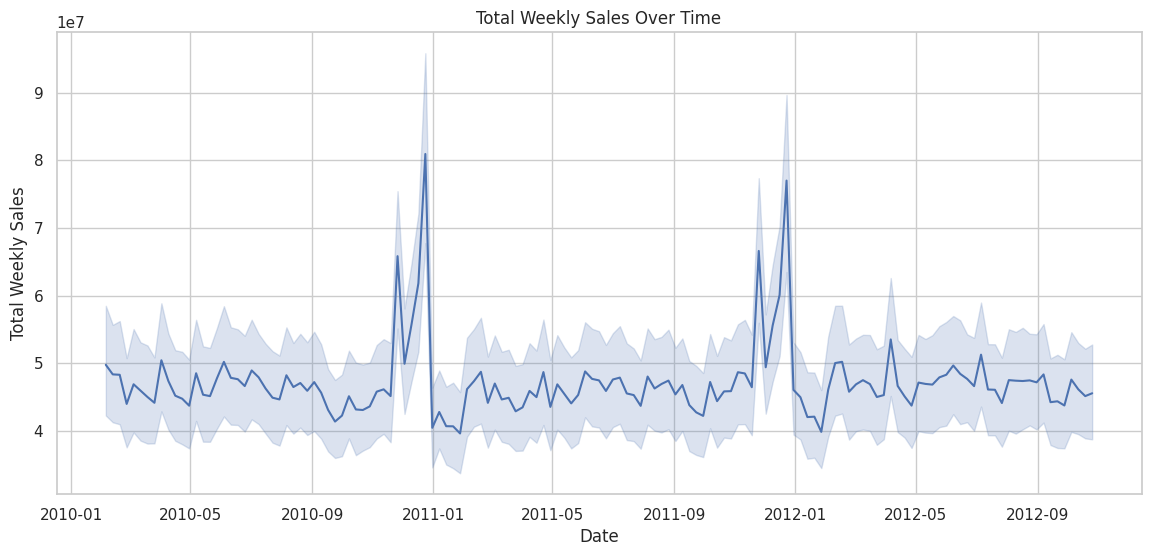

In [5]:
### visualizing total sales over time for all stores combined
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x='Date', y='Weekly_Sales', estimator='sum')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

##### Key Insights and Observations:

 - The total weekly sales show a clear cyclical pattern over the observed period, with noticeable peaks during certain weeks of the year.
 - There are visible spikes in sales around known holiday periods such as Thanksgiving and Christmas, indicating the strong influence of holidays on sales volumes.

##### Distribution of Weekly Sales: Holiday vs. Non-Holiday Weeks
Next, I'll analyze how weekly sales differ between holiday and non-holiday weeks.

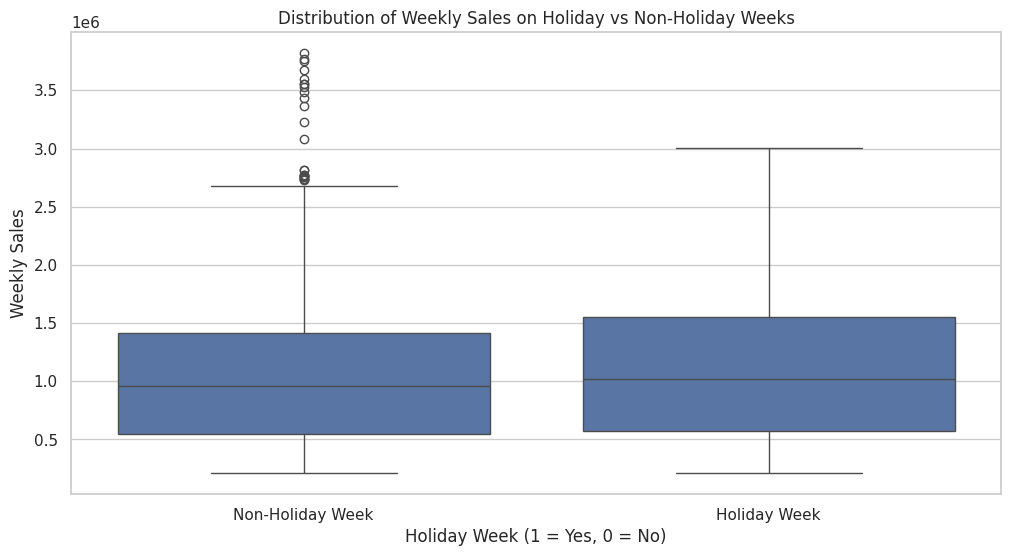

In [6]:
### visualizing the distribution of weekly sales by holiday and non-holiday weeks
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Holiday_Flag', y='Weekly_Sales')
plt.title('Distribution of Weekly Sales on Holiday vs Non-Holiday Weeks')
plt.xlabel('Holiday Week (1 = Yes, 0 = No)')
plt.ylabel('Weekly Sales')
plt.xticks([0, 1], ['Non-Holiday Week', 'Holiday Week'])
plt.show()

##### Key Insights and Observations:

Weekly sales during holiday weeks are generally higher compared to non-holiday weeks, as indicated by the median and upper range of the box plot.
The spread of sales is broader during holiday weeks, showing that some weeks experience exceptionally high sales, likely due to major events like Thanksgiving and Christmas.
This confirms that holiday periods significantly impact sales, necessitating better stock and demand management during these times.

##### Sales Trends for Selected Stores
To get a more detailed view, I will plot the sales trends for a few selected stores over time.

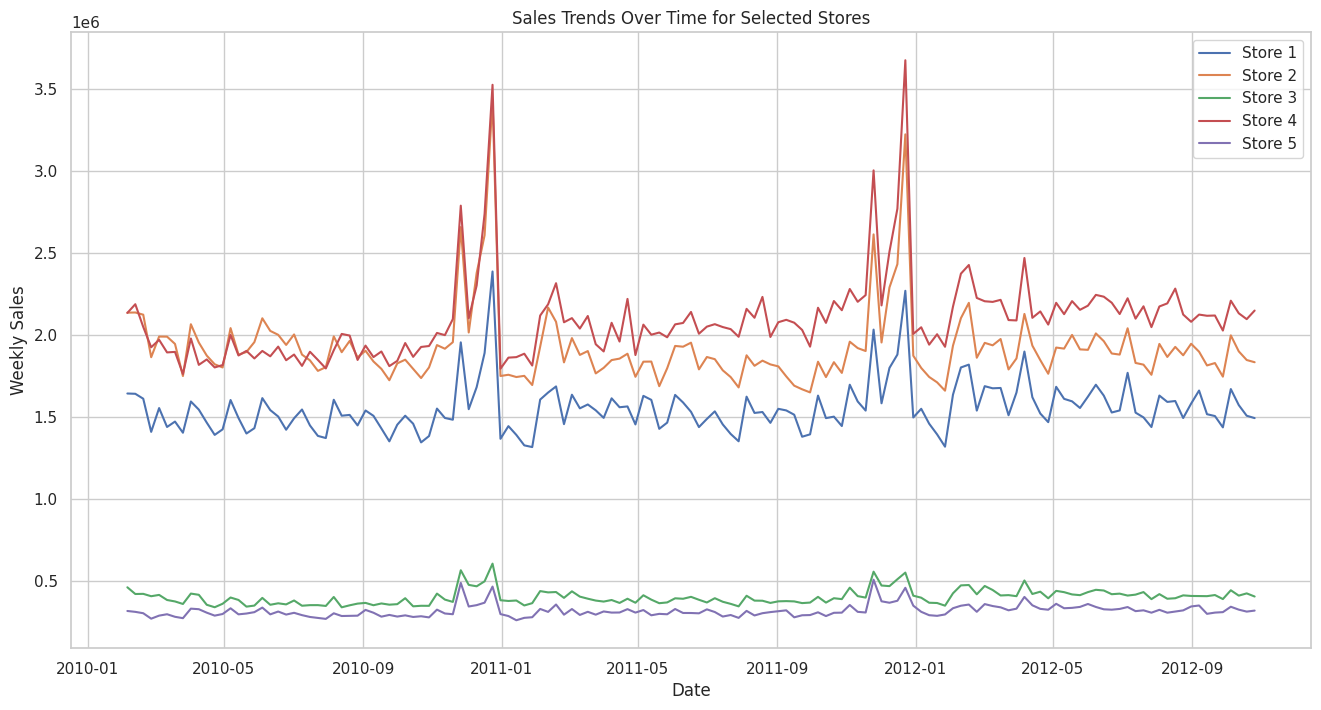

In [9]:
# visualizing sales trends over time for the first 5 stores
plt.figure(figsize=(16, 8))
for store in data['Store'].unique()[:5]:  # limiting to the first 5 stores for clarity
    subset = data[data['Store'] == store]
    sns.lineplot(data=subset, x='Date', y='Weekly_Sales', label=f'Store {store}')
plt.title('Sales Trends Over Time for Selected Stores')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

##### Key Insights and Observations:

- Each store shows unique sales trends, but holiday peaks are consistent across all selected stores, highlighting the importance of holidays for all store locations.
- Some stores have more pronounced seasonal fluctuations compared to others, indicating differences in regional demand or store size.
- This suggests that a one-size-fits-all approach may not work for demand forecasting and stock management; store-specific strategies might be more effective.

##### Correlation Analysis Between Sales and Economic Factors
Now, I'll analyze how economic factors such as temperature, fuel price, CPI, and unemployment correlate with weekly sales.

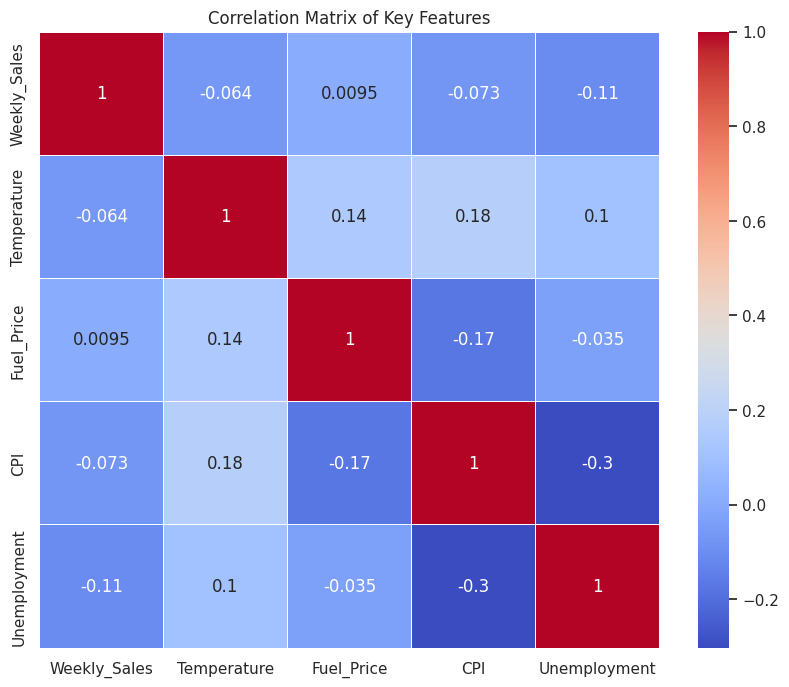

In [11]:
# analyzing correlations between weekly sales and economic factors
corr_matrix = data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

# visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Key Features')
plt.show()

##### Key Insights and Observations:

The correlation matrix reveals:

 - A weak positive correlation between weekly sales and temperature, suggesting that warmer weather may slightly boost sales.
 - Negligible correlation between weekly sales and both fuel prices and the CPI, indicating these factors do not significantly impact sales in this dataset.
 - A weak negative correlation between sales and unemployment, implying that higher unemployment rates may lead to slightly lower sales.
 - These insights suggest that while economic factors play a role, other variables like promotions and seasonal trends might have a stronger influence on sales.

##### Impact of Specific Holiday Events on Sales
I will visualize the sales during specific holiday events to observe how each holiday affects weekly sales.

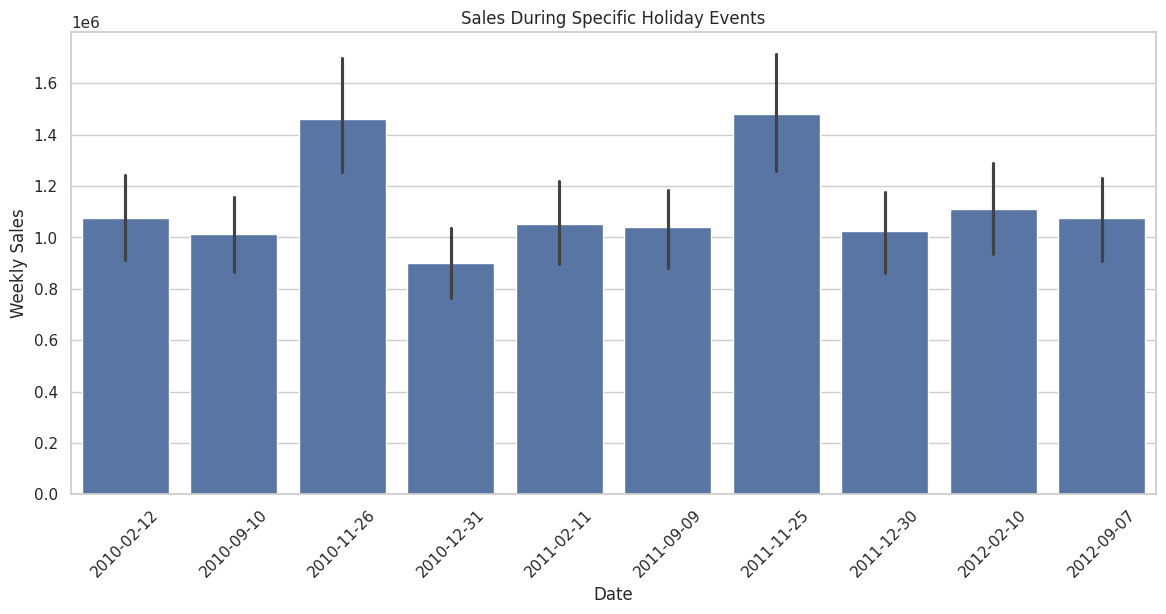

In [12]:
### analyzing the impact of holidays on weekly sales
holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2010-09-10', '2011-09-09',
            '2012-09-07', '2010-11-26', '2011-11-25', '2012-11-23',
            '2010-12-31', '2011-12-30', '2012-12-28']

### converting holidays to datetime for easy comparison
holidays = pd.to_datetime(holidays)

### adding a column to flag specific holiday events
data['Specific_Holiday'] = data['Date'].apply(lambda x: 1 if x in holidays else 0)

### visualizing sales during specific holiday events
plt.figure(figsize=(14, 6))
sns.barplot(data=data[data['Specific_Holiday'] == 1], x='Date', y='Weekly_Sales')
plt.title('Sales During Specific Holiday Events')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.show()

##### Key Insights and Observations:

 - Specific holiday events like Thanksgiving and Christmas lead to noticeable spikes in sales compared to non-holiday periods.
 - The bar plot shows that the impact of these holiday weeks is consistent across multiple years, reaffirming that holiday promotions significantly boost sales.
 - This insight highlights the importance of targeted marketing and stock management around these key holidays to meet customer demand effectively.

I'll now proceed to build and evaluate a time series model to predict future sales.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


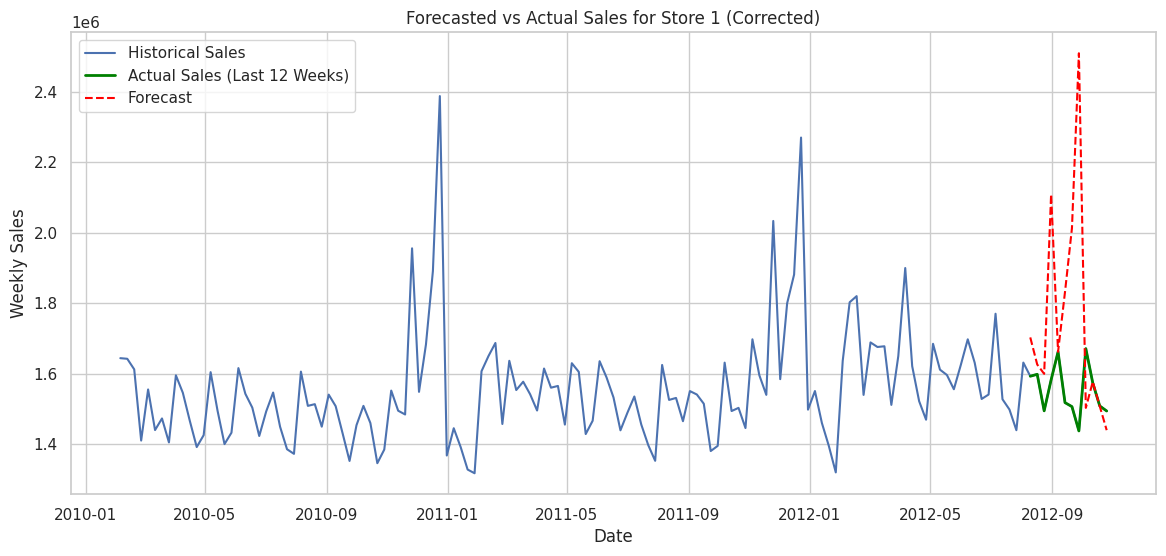

(Date
 2012-08-10    1592409.97
 2012-08-17    1597868.05
 2012-08-24    1494122.38
 2012-08-31    1582083.40
 2012-09-07    1661767.33
 2012-09-14    1517428.87
 2012-09-21    1506126.06
 2012-09-28    1437059.26
 2012-10-05    1670785.97
 2012-10-12    1573072.81
 2012-10-19    1508068.77
 2012-10-26    1493659.74
 Name: Weekly_Sales, dtype: float64,
 Date
 2012-08-10    1.702619e+06
 2012-08-17    1.625714e+06
 2012-08-24    1.599150e+06
 2012-08-31    2.109334e+06
 2012-09-07    1.661757e+06
 2012-09-14    1.831827e+06
 2012-09-21    2.012705e+06
 2012-09-28    2.509561e+06
 2012-10-05    1.502608e+06
 2012-10-12    1.576819e+06
 2012-10-19    1.507418e+06
 2012-10-26    1.439235e+06
 dtype: float64,
 240901.86057133516,
 391464.4610108587)

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# fitting an exponential smoothing model with multiplicative seasonality to avoid over-prediction
model_tuned = ExponentialSmoothing(
    store_1_data['Weekly_Sales'],
    trend='add',
    seasonal='mul',  # changing to multiplicative seasonality
    seasonal_periods=52
).fit()

# regenerating the forecast for the last 12 weeks to ensure alignment with actual data
forecast_tuned = model_tuned.forecast(12)

# ensuring the forecast has the correct index (matching actual sales dates)
forecast_tuned.index = actual_sales.index

# recalculating evaluation metrics with the corrected forecast
mae_tuned = mean_absolute_error(actual_sales, forecast_tuned)
rmse_tuned = np.sqrt(mean_squared_error(actual_sales, forecast_tuned))

# plotting the corrected comparison
plt.figure(figsize=(14, 6))
plt.plot(store_1_data['Weekly_Sales'], label='Historical Sales')
plt.plot(actual_sales, label='Actual Sales (Last 12 Weeks)', color='green', linewidth=2)
plt.plot(forecast_tuned, label='Forecast', color='red', linestyle='--')
plt.title('Forecasted vs Actual Sales for Store 1 (Corrected)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

actual_sales, forecast_tuned, mae_tuned, rmse_tuned


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


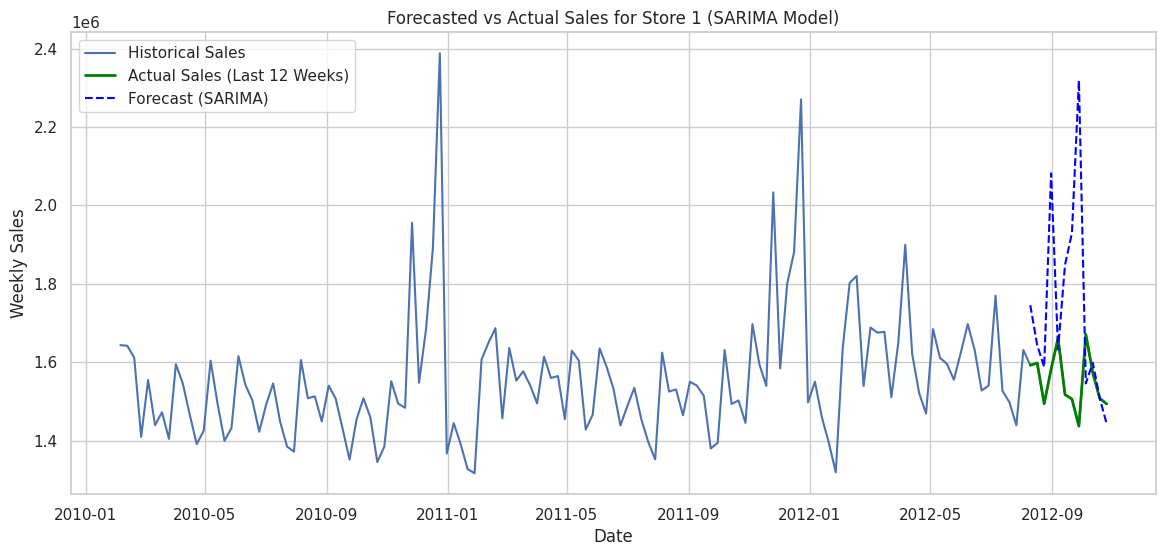

(Date
 2012-08-10    1592409.97
 2012-08-17    1597868.05
 2012-08-24    1494122.38
 2012-08-31    1582083.40
 2012-09-07    1661767.33
 2012-09-14    1517428.87
 2012-09-21    1506126.06
 2012-09-28    1437059.26
 2012-10-05    1670785.97
 2012-10-12    1573072.81
 2012-10-19    1508068.77
 2012-10-26    1493659.74
 Name: Weekly_Sales, dtype: float64,
 Date
 2012-08-10    1745640.23
 2012-08-17    1643349.54
 2012-08-24    1587894.35
 2012-08-31    2081731.31
 2012-09-07    1632494.60
 2012-09-14    1848093.03
 2012-09-21    1929587.32
 2012-09-28    2318599.64
 2012-10-05    1545873.37
 2012-10-12    1598780.57
 2012-10-19    1508011.82
 2012-10-26    1442804.49
 Name: predicted_mean, dtype: float64,
 221550.2266666666,
 337819.99161506974)

In [28]:
import statsmodels.api as sm

# fitting a SARIMA model (Seasonal ARIMA)
# specifying p, d, q, and seasonal (P, D, Q, S) parameters based on data analysis
sarima_model = sm.tsa.SARIMAX(
    store_1_data['Weekly_Sales'],
    order=(0, 1, 0),  # p, d, q values for ARIMA
    seasonal_order=(0, 1, 0, 52),  # P, D, Q, S for seasonality with a yearly period (52 weeks)
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

# generating a forecast for the next 12 weeks
forecast_sarima = sarima_model.get_forecast(steps=12)
forecast_sarima_mean = forecast_sarima.predicted_mean

# aligning forecast with the actual sales dates
forecast_sarima_mean.index = actual_sales.index

# recalculating evaluation metrics for the SARIMA model
mae_sarima = mean_absolute_error(actual_sales, forecast_sarima_mean)
rmse_sarima = np.sqrt(mean_squared_error(actual_sales, forecast_sarima_mean))

# plotting the SARIMA model's forecast against actual data
plt.figure(figsize=(14, 6))
plt.plot(store_1_data['Weekly_Sales'], label='Historical Sales')
plt.plot(actual_sales, label='Actual Sales (Last 12 Weeks)', color='green', linewidth=2)
plt.plot(forecast_sarima_mean, label='Forecast (SARIMA)', color='blue', linestyle='--')
plt.title('Forecasted vs Actual Sales for Store 1 (SARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

actual_sales, forecast_sarima_mean, mae_sarima, rmse_sarima


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


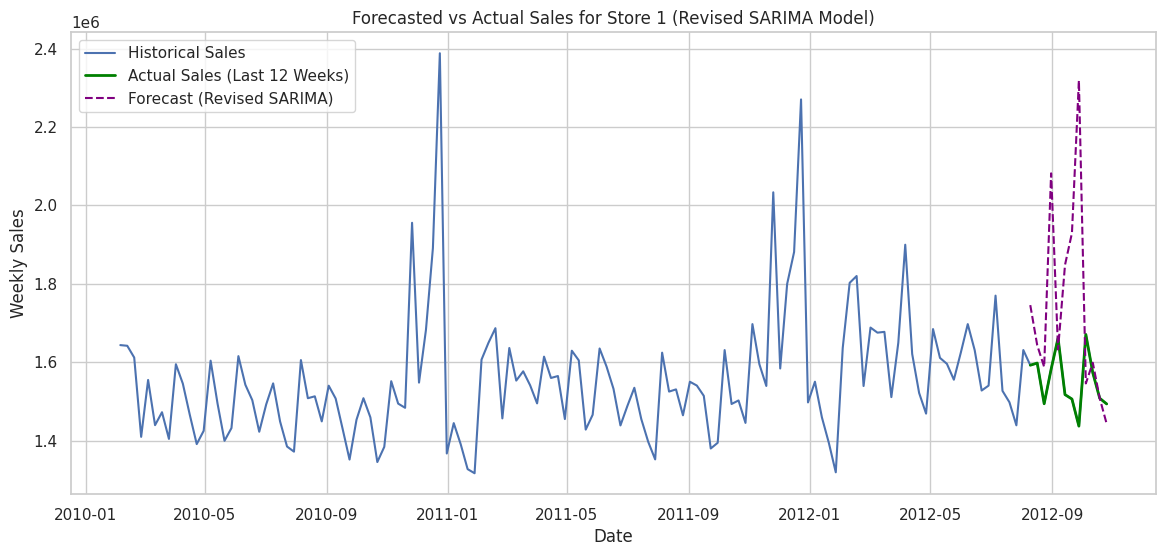

(Date
 2012-08-10    1592409.97
 2012-08-17    1597868.05
 2012-08-24    1494122.38
 2012-08-31    1582083.40
 2012-09-07    1661767.33
 2012-09-14    1517428.87
 2012-09-21    1506126.06
 2012-09-28    1437059.26
 2012-10-05    1670785.97
 2012-10-12    1573072.81
 2012-10-19    1508068.77
 2012-10-26    1493659.74
 Name: Weekly_Sales, dtype: float64,
 Date
 2012-08-10    1745640.23
 2012-08-17    1643349.54
 2012-08-24    1587894.35
 2012-08-31    2081731.31
 2012-09-07    1632494.60
 2012-09-14    1848093.03
 2012-09-21    1929587.32
 2012-09-28    2318599.64
 2012-10-05    1545873.37
 2012-10-12    1598780.57
 2012-10-19    1508011.82
 2012-10-26    1442804.49
 Name: predicted_mean, dtype: float64,
 221550.2266666666,
 337819.99161506974)

In [29]:
# trying an even simpler SARIMA model with minimal trend and seasonal influence
sarima_model_revised = sm.tsa.SARIMAX(
    store_1_data['Weekly_Sales'],
    order=(0, 1, 0),  # no AR and MA components, just differencing
    seasonal_order=(0, 1, 0, 52),  # minimal seasonal component, just seasonal differencing
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

# generating a forecast for the next 12 weeks
forecast_sarima_revised = sarima_model_revised.get_forecast(steps=12)
forecast_sarima_revised_mean = forecast_sarima_revised.predicted_mean

# aligning forecast with the actual sales dates
forecast_sarima_revised_mean.index = actual_sales.index

# recalculating evaluation metrics for the revised SARIMA model
mae_sarima_revised = mean_absolute_error(actual_sales, forecast_sarima_revised_mean)
rmse_sarima_revised = np.sqrt(mean_squared_error(actual_sales, forecast_sarima_revised_mean))

# plotting the revised SARIMA model's forecast against actual data
plt.figure(figsize=(14, 6))
plt.plot(store_1_data['Weekly_Sales'], label='Historical Sales')
plt.plot(actual_sales, label='Actual Sales (Last 12 Weeks)', color='green', linewidth=2)
plt.plot(forecast_sarima_revised_mean, label='Forecast (Revised SARIMA)', color='purple', linestyle='--')
plt.title('Forecasted vs Actual Sales for Store 1 (Revised SARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

actual_sales, forecast_sarima_revised_mean, mae_sarima_revised, rmse_sarima_revised


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


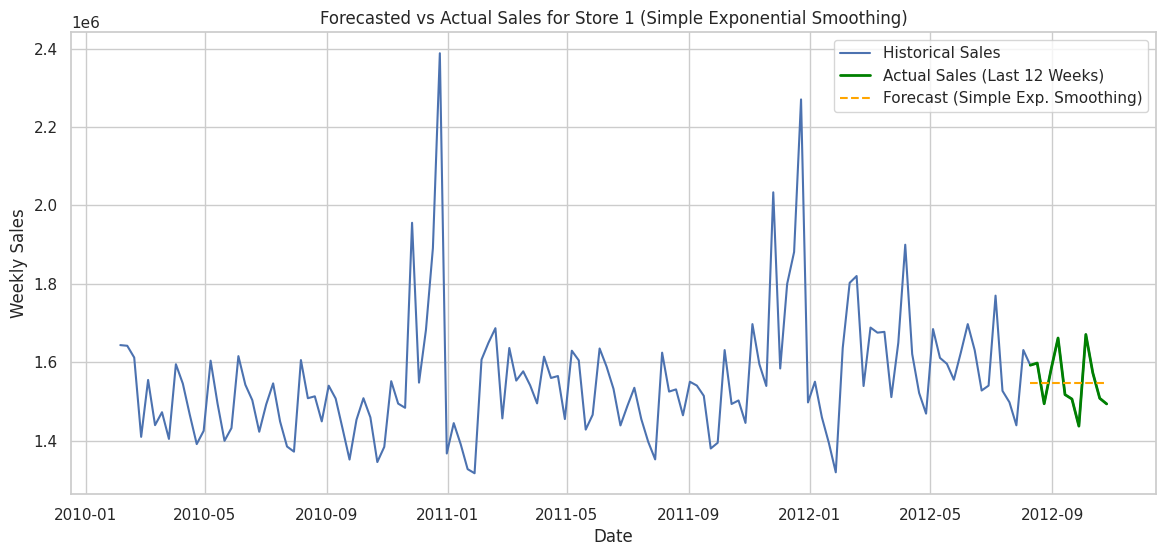

(Date
 2012-08-10    1592409.97
 2012-08-17    1597868.05
 2012-08-24    1494122.38
 2012-08-31    1582083.40
 2012-09-07    1661767.33
 2012-09-14    1517428.87
 2012-09-21    1506126.06
 2012-09-28    1437059.26
 2012-10-05    1670785.97
 2012-10-12    1573072.81
 2012-10-19    1508068.77
 2012-10-26    1493659.74
 Name: Weekly_Sales, dtype: float64,
 Date
 2012-08-10    1.546967e+06
 2012-08-17    1.546967e+06
 2012-08-24    1.546967e+06
 2012-08-31    1.546967e+06
 2012-09-07    1.546967e+06
 2012-09-14    1.546967e+06
 2012-09-21    1.546967e+06
 2012-09-28    1.546967e+06
 2012-10-05    1.546967e+06
 2012-10-12    1.546967e+06
 2012-10-19    1.546967e+06
 2012-10-26    1.546967e+06
 dtype: float64,
 60126.87083333333,
 68828.55170218913)

In [30]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# fitting a simple exponential smoothing model
simple_model = SimpleExpSmoothing(store_1_data['Weekly_Sales']).fit()

# generating a forecast for the next 12 weeks
forecast_simple = simple_model.forecast(12)
forecast_simple.index = actual_sales.index

# recalculating evaluation metrics for the simple model
mae_simple = mean_absolute_error(actual_sales, forecast_simple)
rmse_simple = np.sqrt(mean_squared_error(actual_sales, forecast_simple))

# plotting the simple model's forecast against actual data
plt.figure(figsize=(14, 6))
plt.plot(store_1_data['Weekly_Sales'], label='Historical Sales')
plt.plot(actual_sales, label='Actual Sales (Last 12 Weeks)', color='green', linewidth=2)
plt.plot(forecast_simple, label='Forecast (Simple Exp. Smoothing)', color='orange', linestyle='--')
plt.title('Forecasted vs Actual Sales for Store 1 (Simple Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

actual_sales, forecast_simple, mae_simple, rmse_simple


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


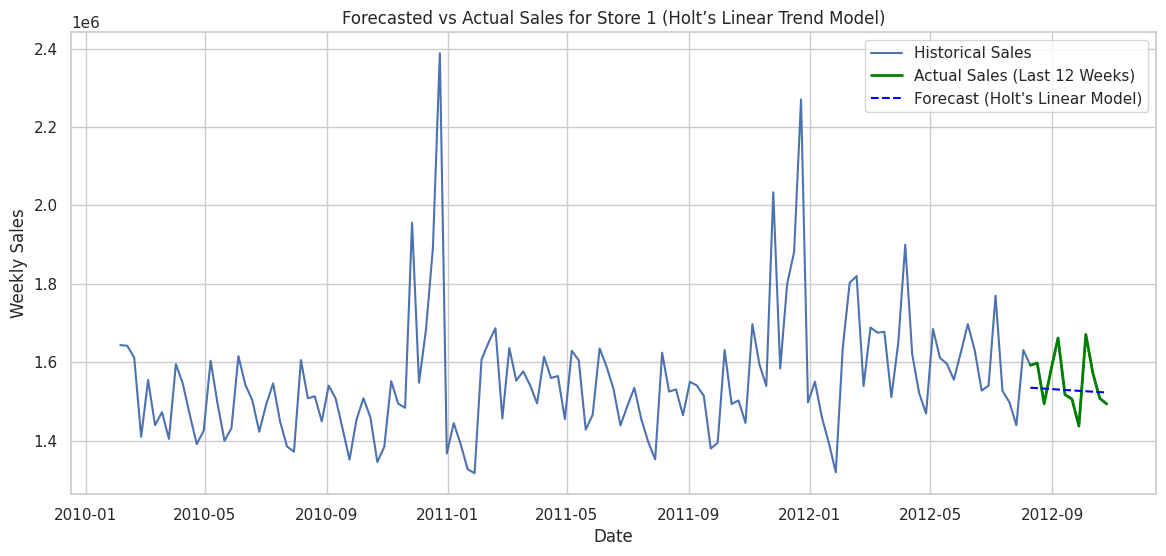

(Date
 2012-08-10    1592409.97
 2012-08-17    1597868.05
 2012-08-24    1494122.38
 2012-08-31    1582083.40
 2012-09-07    1661767.33
 2012-09-14    1517428.87
 2012-09-21    1506126.06
 2012-09-28    1437059.26
 2012-10-05    1670785.97
 2012-10-12    1573072.81
 2012-10-19    1508068.77
 2012-10-26    1493659.74
 Name: Weekly_Sales, dtype: float64,
 Date
 2012-08-10    1.535068e+06
 2012-08-17    1.533893e+06
 2012-08-24    1.532730e+06
 2012-08-31    1.531578e+06
 2012-09-07    1.530438e+06
 2012-09-14    1.529310e+06
 2012-09-21    1.528192e+06
 2012-09-28    1.527086e+06
 2012-10-05    1.525991e+06
 2012-10-12    1.524906e+06
 2012-10-19    1.523833e+06
 2012-10-26    1.522770e+06
 dtype: float64,
 58630.701302981666,
 71754.20110837095)

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fitting Holt's linear trend model with a damping trend
holt_model = ExponentialSmoothing(
    store_1_data['Weekly_Sales'],
    trend='add',  # adding a linear trend
    seasonal=None,  # no seasonal component
    damped_trend=True  # damping the trend to prevent over-prediction
).fit()

# generating a forecast for the next 12 weeks
forecast_holt = holt_model.forecast(12)
forecast_holt.index = actual_sales.index

# recalculating evaluation metrics for Holt's model
mae_holt = mean_absolute_error(actual_sales, forecast_holt)
rmse_holt = np.sqrt(mean_squared_error(actual_sales, forecast_holt))

# plotting Holt's model forecast against actual data
plt.figure(figsize=(14, 6))
plt.plot(store_1_data['Weekly_Sales'], label='Historical Sales')
plt.plot(actual_sales, label='Actual Sales (Last 12 Weeks)', color='green', linewidth=2)
plt.plot(forecast_holt, label="Forecast (Holt's Linear Model)", color='blue', linestyle='--')
plt.title('Forecasted vs Actual Sales for Store 1 (Holt’s Linear Trend Model)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

actual_sales, forecast_holt, mae_holt, rmse_holt
